<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Introduction to image similarity

Image similarity is often used to build Image Retrieval systems where, given a query image, the goal is to find all similar images in a reference set. These systems can be used e.g. on a shopping website to suggest users comparable products.

In this tutorial we build an image retrieval system based on leveraging DNNs trained for image classification. Given a query image, we can then find the most similar images in the reference set by computing the pairwise distances as illustrated below, and by returning the reference images with the lowest distance to the query image. 

The distance between two images is computed by:
<img src="media/image_similarity_diagram2.jpg" width="600px" />

- Representing each image using the output of a DNN which was pre-trained on millions of images, and fine-tuned on images from the same domain. The input to the DNN is an image, and the output is the penultimate layer which, for the ResNet-18 model used in this tutorial, consists of 512-floating point values. Note that we use only a single DNN which takes each of the two images in turn as input.
- Normalizing each of the 512-floats DNN image representations (aka. embeddings or features) to have a L2 norm of one.
- Finally, computing the distance between the two input images given as the L2 distance between their respective DNN representations.

Representing images as the output of a DNN is a powerful approach and shown to give good results on a wide variety of tasks.

This notebook starts by loading a dataset and splitting it into a training and a validation set. The training set is used to refine an ImageNet pre-trained ResNet-18 DNN, which is then used to compute the DNN features for each image. The validation set is used in an image retrieval example where, given a query image, the top similar images are displayed, followed by a quantitative evaluation of the proposed system.


<i><b>Note:</b> We will use the terms `embedding` and `feature` interchangeably throughout this tutorial, to refer to the DNN representation for each image.</i>

## Initialization <a id="libraries"/>

In [1]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# Regular python libraries
#from copy import deepcopy
import sys
import numpy as np
from pathlib import Path
import random

# fast.ai
import fastai
from fastai.vision import *

# Computer Vision repository
sys.path.extend([".", "../.."]) # to access the utils_cv library
from utils_cv.classification.data import Urls
from utils_cv.classification.model import TrainMetricsRecorder
from utils_cv.common.data import unzip_url
from utils_cv.common.gpu import which_processor
from utils_cv.similarity.data import comparative_set_builder
from utils_cv.similarity.metrics import compute_distances, positive_image_rank_list, recall_at_k, vector_distance
from utils_cv.similarity.model import compute_features
from utils_cv.similarity.plot import plot_comparative_set, plot_rank_and_set_size, plot_distances, plot_recalls

In [3]:
print(f"Fast.ai version = {fastai.__version__}")
#which_processor()

Fast.ai version = 1.0.53.post2


## Data preparation <a id="data-prep"/>

We start with the preparation of our data, and the setting of a few parameters. We use our *Fridge objects* dataset, which is composed of 134 images, divided into 4 classes: can, carton, milk bottle and water bottle. Change the `DATA_PATH` variable below to point to a different (single-label) dataset.

In [5]:
# Set dataset, model and evaluation parameters
DATA_PATH     = unzip_url(Urls.fridge_objects_path, exist_ok=True)

# DNN configuration and learning parameters 
EPOCHS_HEAD = 1 #4
EPOCHS_BODY = 1 #12
LEARNING_RATE = 1e-4
DROPOUT_RATE = 0.5
BATCH_SIZE    = 16
ARCHITECTURE  = models.resnet18
IM_SIZE       = 300

We can now build our training data object, and split it to get a certain percentage (here 20%) assigned to a validation set.

Training set: 108 images
Validation set: 26 images


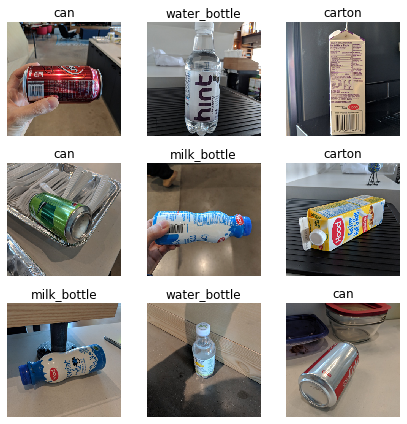

In [6]:
# Load images into fast.ai's ImageDataBunch object
random.seed(642)
data = (ImageList.from_folder(DATA_PATH) 
        .split_by_rand_pct(valid_pct=0.2, seed=20) 
        .label_from_folder() 
        .transform(size=IM_SIZE) 
        .databunch(bs=BATCH_SIZE) 
        .normalize(imagenet_stats))

print(f'Training set: {len(data.train_ds.x)} images\nValidation set: {len(data.valid_ds.x)} images')

# Display example images
data.show_batch(rows=3, figsize=(6,6))

## Classification model fine-tuning <a id="classif"/>

We begin by retrieving a [ResNet18](https://arxiv.org/pdf/1512.03385.pdf) model from fast.ai's library which is pre-trained on ImageNet, and fine-tune the model using our training set. We use the same training parameters here and take the same approach as what we did in our [classification notebooks](https://github.com/microsoft/ComputerVision/tree/master/classification/notebooks), training first the (new) last layer only, and then the full DNN.

In [7]:
learn = cnn_learner(
    data,
    ARCHITECTURE,
    metrics=[accuracy],
    callback_fns=[partial(TrainMetricsRecorder, show_graph=True)],
    ps=DROPOUT_RATE
)

epoch,train_loss,valid_loss,train_accuracy,valid_accuracy,time
0,1.753460,1.317349,0.260417,0.461538,00:48


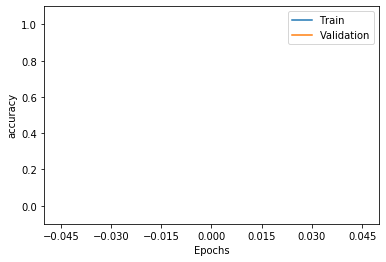

In [8]:
# Train the last layer
learn.fit_one_cycle(EPOCHS_HEAD, LEARNING_RATE)

Let's now unfreeze all the layers and fine tune the model with our data

epoch,train_loss,valid_loss,train_accuracy,valid_accuracy,time
0,1.627404,1.281624,0.333333,0.461538,00:45


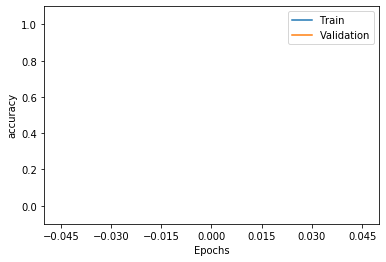

In [9]:
learn.unfreeze()
learn.fit_one_cycle(EPOCHS_BODY, LEARNING_RATE)

## Feature extraction <a id="feat"/>

Before computing the feature representation for each image, let's look at its architecture.

In [10]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

Let's, more particularly, focus on the last part. Fast.ai's version of this model is composed of a different set of layers (here: `(1): Sequential`). As discussed at the start of this notebook, we use the output of the penultimate layer (here: `(6): BatchNorm1d`) as our image representation.

The following line will allow us to extract the penultimate layer (ie 512 floating points vector) after running an image  through the model.

In [11]:
# Use last batch normalization layer as image representation. [1][6] correspond to the indices discussed above
embedding_layer = learn.model[1][6] 
print(embedding_layer)

BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [12]:
#Compute DNN features for all training and validation images
train_features = compute_features(data.train_ds, learn, embedding_layer)
valid_features = compute_features(data.valid_ds, learn, embedding_layer)

## Image Retrieval Example
The code sample below shows how to find and display the the most similar images in the validation set for a given query image (which we also select from the validation set). This example is similar to the one shown in the [00_webcam.ipynb](00_webcam.ipynb) notebook. 

We use the L2 distance, which is defined as $ \sqrt{\sum_{i=1}^{n}{(F_{q}[i] - F_{r}[i])^{2}}} $, where $F_{q}$ and $F_{r}$ are the features of a query image and a reference image respectively, and $n=512$ is the dimension of the features. By default, we normalize the vectors $F_{q}$ and $F_{r}$ to be unit length, ie have a magnitude ||$F$|| of 1, before computing the L2 distance. One could also use other types of distances, such as L1 or cosine similarity, however L2 with unit-length normalized feature vectors seems to work well in practice. 

Query image path: C:\Users\pabuehle\Desktop\ComputerVision\data\fridgeObjects\milk_bottle\72.jpg
Most similar image with distance 0.00: C:\Users\pabuehle\Desktop\ComputerVision\data\fridgeObjects\milk_bottle\72.jpg
Second most similar image with distance 1.36: C:\Users\pabuehle\Desktop\ComputerVision\data\fridgeObjects\carton\47.jpg


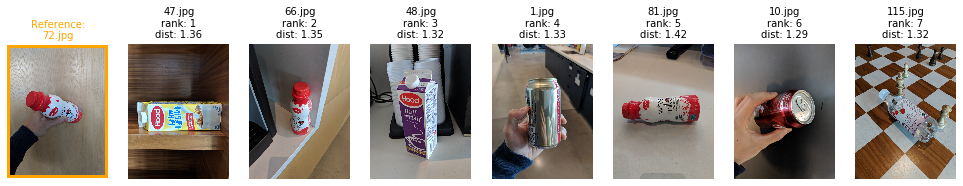

In [13]:
# Get the DNN feature for the query image
query_im_path =  str(data.valid_ds.items[0])
query_feature = valid_features[query_im_path]
print(f"Query image path: {query_im_path}")

# Compute the distances between the query and all reference images
distances = compute_distances(query_feature, valid_features)
print(f"Most similar image with distance {distances[0][1]:.2f}: {distances[0][0]}")
print(f"Second most similar image with distance {distances[1][1]:.2f}: {distances[1][0]}")
plot_distances(distances, num_rows=1, num_cols=8, figsize=(17,5))

## Quantitative evaluation

To measure accuracy of our image similarity measure, we create so called "comparative sets" from the test images. Each comparative set consists of a `query` image and 100 random `distractor` images where exactly 1 of the 100 images has the same label as the query image. We will refer to this image as positive, and the other 99 images are negatives. When sorting the 100 distractor images according to their distance to the query image, a perfect image similarity system would place the positive image at the top before all negative images ie. at rank 1. This is shown in the example below.

<img src="media/ranking_example.jpg" width="600px" />



### Comparative sets creation <a id="compar-sets"/>

In the cells below, we construct comparative sets from the validation images using our `comparative_set_builder` helper function. Each validation image is used exactly once as query, and hence we obtain as many comparative sets as there are images in the validation set. 

In [14]:
# Build multiple sets of comparative images from the images of the validation set
comparative_sets = comparative_set_builder(data.valid_ds)
print(f"Generated {len(comparative_sets)} comparative image sets.")

Generated 26 comparative image sets.


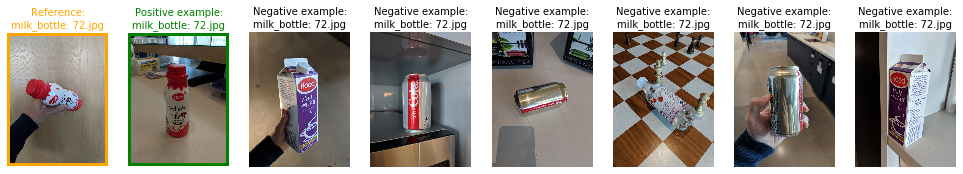

In [15]:
# Plot the query image, the positive example and some of the negative examples of the "first" comparative set.
plot_comparative_set(comparative_sets[0], 8, figsize=(17,5))

In [16]:
# For each comparative set compute the distances between the query images and all reference images
for cs in comparative_sets:
    cs.compute_distances(valid_features)

### Evaluation

To assess the accuracy of our model, we compute these two statistics:
- Median rank: median rank of the positive example across all comparative sets. A value of 1 being best, 100 worst, and 50 random chance guessing.
- Recall at k: percentage of positive examples within the top k, ie. with rank <= k. A value of 100% being best, 0% worst, and at k=1 or k=5 random chance guessing of 1% or 5% respectively.

In [17]:
# Compute the median rank of the positive example over all comparative sets
rank_list = positive_image_rank_list(comparative_sets)
median_rank = np.median(rank_list)
print(f"The positive example ranks {median_rank}, as a median, across our {len(rank_list)} comparative sets")

The positive example ranks 6.5, as a median, across our 26 comparative sets


The positive image is:
 --> 15.4% of the time the most similar to the query      
 --> 42.3% of the time in the top 5 images       
 --> 73.1% of the time in the top 10 images


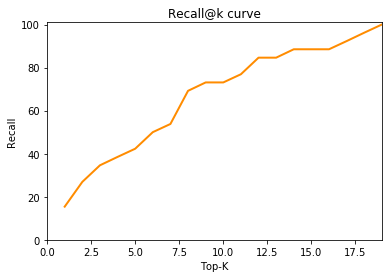

In [18]:
# Compute recall at k=1, 5, and 10
print(f"The positive image is:\n --> {recall_at_k(rank_list, 1)}% of the time the most similar to the query\
      \n --> {recall_at_k(rank_list, 5)}% of the time in the top 5 images \
      \n --> {recall_at_k(rank_list, 10)}% of the time in the top 10 images")

# Plot recall versus k
plot_recalls(rank_list)

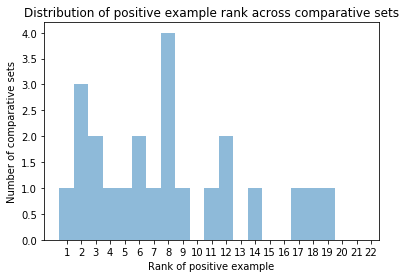

In [19]:
# Display the distribution of positive example ranks and of sizes of comparative sets 
# (Set show_set_size=False to only display the distribution of ranks)
set_sizes = [len(cs.neg_im_paths) for cs in comparative_sets]
plot_rank_and_set_size(rank_list, set_sizes, show_set_size=False)

## Appendix <a id="appendix"/>

### Fast image retrieval

In the code above, we use the function `compute_similars()` to compute the distances between a query image and all images in the validation set to find the closest match. While computing the L2 distance between two images is fast, for large datasets this exhaustive brute-force search can be too slow for real-time applications.

In that case, it is preferable to use an approximate method that is optimized for large datasets (N) and high dimensional DNN features (D). A [Ball Tree] is a popular approach, with query time growing as O\[D\*log(N)\], compared to O\[D\*N\] for brute force. 

In the cell below, we demonstrate how to do fast image retrieval using scikit-learn's [NearestNeighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html) object. Note that we normalized the embeddings, and chose "euclidean" distance, to match our "L2" distance from above which we have seen to often work well in practice.


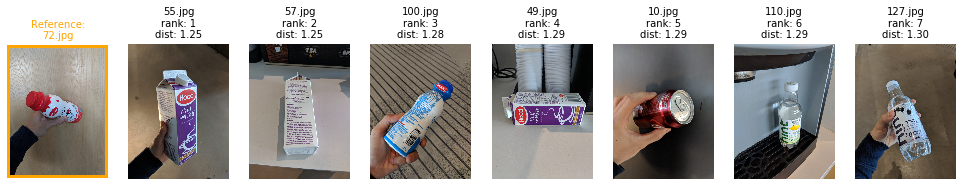

In [22]:
from sklearn.neighbors import NearestNeighbors

# Normalize query and all reference features to be unit length
query_feature /= np.linalg.norm(query_feature, 2)
reference_features = np.array(list(valid_features.values()))
reference_features /= np.linalg.norm(reference_features, axis=1)[:,None]

# Build the tree using the reference features
nn = NearestNeighbors(n_neighbors = 10, algorithm='auto', metric='euclidean').fit(reference_features)

# Query the tree to find all images which are similar to the query image
query_feature = np.reshape(query_feature, (-1, 512))
approx_distances, approx_im_indices = nn.kneighbors(query_feature)

# Display the results
approx_im_paths = [str(data.valid_ds.items[i]) for i in approx_im_indices[0]]
plot_distances(list(zip(approx_im_paths, approx_distances[0])), 
               num_rows=1, num_cols=8, figsize=(17,5))

UNUSED TEXT:

As shown on the diagram below, this image retrivel notebook implements the follow steps:
1. Fine tune an image classification DNN using an annotated training dataset.
1. Use this DNN to compute a feature representation for each image, given by the activation of the penultimate layer of the DNN. In this example, the representation (also referred to as image embedding) consists of 512 floating point values which are normalized to have an L2 norm of 1.
1. Given a query image, compute the distance to all images in a reference set. This is based on a metric which takes the DNN embeddings of two images as input, and outputs the L2 distance between them.
1. Sort and return the images with lowest distance.

For each comparative set:
2. Run each image of the set, separately, through this model, and extract the values obtained in the penultimate layer of the model
   - This layer is the last one before the probabilities of each class are computed
   - These values constitute a vector that is often called `image embedding`
   - For the model we are considering here, this vector is composed of 512 float values
3. Compute the $L_2$ distance between the reference image, and each of the other images of the comparative set, using their respective image embeddings
4. Sort the images as a function of distance to the reference image
5. Rank these images, rank 1 being assigned to the closest image to the reference one.


We will focus on 2 metrics: `positive in top k` and `median rank`. They essentially track how good our model is at generating image embeddings, such that the positive example (i.e. image of the same class as the reference) is the closest of the comparative images to the reference one.

Each comparative set is composed of:

- <b>A reference image:</b> image to which the rest of the images of the set will be compared to find similar images to it
- <b>A positive example:</b> image of the same class as the reference image -- If our model is well trained, we expect the positive example to be the image the most similar to the reference image
- <b>Negative examples:</b> set of images from all the other classes -- We expect these to be "further away" from the reference image than the positive example

Due to the randomness of the split between training and validation data, the number of images in each of the "other" classes may differ.





Since we want to compare image embeddings to determine image similarity, we first need to extract these embeddings. We will do so by running our images through a trained classifier model, such as the one we trained in the [01_training_introduction.ipynb](../../classification/notebooks/01_training_introduction.ipynb) notebook.

For each of our comparative sets, we can now use our model to extract the corresponding image embeddings, compute the distances to the reference image, and rank the other images by distance to it.

For this, we need to first:
- Save, through the `SaveFeatures()` hook, the features we obtained from the batch normalization layer we referenced above
- Run the comparative set of images through the model we trained, and get the corresponding predictions using `predict()`
- Extract the values of the features we just saved, i.e. the image embeddings we need to find similar images.


In cases where the results are not as good, training on a bigger dataset, or changing the [dropout rate `ps`](https://docs.fast.ai/vision.learner.html#cnn_learner) or the learning rate may improve the outcome.

**Alternative visualization**: With our `DistanceWidget`, we can display the results in a different fashion. Here, we can interact with a user interface and navigate between the images of a comparative set, in distance order. In the example below, we consider the first comparative set we processed.

```python
from utils_cv.similarity.widget import DistanceWidget
w_results = DistanceWidget(
    dataset=data.valid_ds,
    distances=[s[1] for s in similars],
    query_im_path = query_im_path
)
display(w_results.show())
```